In [1]:
import gc
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
# This is for the progress bar.
from tqdm.auto import tqdm
import random
from pathlib import Path
import math

In [2]:
myseed = 1091102  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [3]:
def padding(ball_pos , f_range , cond , front = True):
    x = []
    x = ball_pos[cond]

    for _ in range(f_range - len(x)):

        pad = pd.DataFrame([[0,0,0,0,0]],columns= ball_pos.columns)
        if front == True:
            ball_pos = pd.concat([pad , ball_pos])
        else:
            ball_pos = pd.concat([ball_pos , pad])

    return ball_pos

In [4]:
class BadmintonDataset(Dataset):

    def __init__(self,path,tfm,ball_path,files = None):
        super(BadmintonDataset).__init__()
        self.path = path
        
        if files != None:
            self.files = files
        else:
            self.files = [] 
            for i in Path(path).glob('*'):
                self.files.append(i)
        self.ball_pos = pd.read_csv(ball_path)
        self.transform = tfm
        
    
    
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = str(self.files[idx])
        im = Image.open(fname)
        im = self.transform(im)
        
        f_range = 30
        frame = int(fname.split("_")[-2].strip('.'))
        vid = int(fname.split('/')[-1].split("_")[-3].strip('.'))
        label = int(fname.split("_")[-1].strip('.jpg'))
        
        if label == 1: 
            label = 0
        elif label ==2:
            label = 1
        
        cond = (self.ball_pos['VideoName'] == vid) & (abs(self.ball_pos['Frame'] - frame) <= f_range)  
        ball_pos = self.ball_pos[cond]
        
        if len(ball_pos) == 0 or frame < 2:
            ball_pos = pd.concat([pd.DataFrame([[0,frame,0,0,0]],columns= ball_pos.columns) , ball_pos])
            
        prev_cond = ((frame - ball_pos['Frame']) <= f_range) & ((frame - ball_pos['Frame']) > 0)
        ball_pos = padding(ball_pos , f_range , prev_cond)
        follow_cond = ((ball_pos['Frame'] - frame) <= f_range) & ((ball_pos['Frame'] - frame) > 0)
        ball_pos = padding(ball_pos , f_range , follow_cond , front=False)
            
        ball_pos = torch.tensor(ball_pos[['Visibility','X','Y']].values , dtype = torch.float)
        
#         print(fname , len(ball_pos))

        if torch.flatten(ball_pos).size(0) != 183 :
#             print(img.shape ,ball.size(0) , label)
            print(fname)
                 
        return im , torch.flatten(ball_pos) ,label
    
    

In [5]:
class Classifier(nn.Module):
    def __init__(self , nb_classes):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = models.efficientnet_v2_s(weights = models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
        self.cnn_fc = nn.Linear(1000 , nb_classes)
        
        self.ball_prefc = nn.LazyLinear(100)
        self.ball_attention = nn.TransformerEncoderLayer(100 , 1 , dim_feedforward = 128 , dropout=0.15 , batch_first = True)
        self.ball_fc = nn.LazyLinear(nb_classes)
        self.fin_fc = nn.LazyLinear(nb_classes)
        
    def forward(self, img , ball):
        
        imgout = self.cnn(img)
        imgout = self.cnn_fc(imgout)
        
        ballout = self.ball_prefc(ball)
        ballout = self.ball_attention(ballout)
        ballout = self.ball_fc(ballout)
        out = self.fin_fc(torch.cat((imgout,ballout) , dim = 1))
        
        
        return out

In [6]:
# image_size = (440,310)
image_size = (330,150)
test_tfm = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

train_tfm = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomAdjustSharpness(1.5, p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAutocontrast(p=0.5),
    transforms.ColorJitter(0.2,0.2,0.2,0.05),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5,scale=(0.005,0.015),value=(1,1,1)),
])

In [7]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
nb_classes = 2
model = Classifier(nb_classes).to(device)
batch_size = 32
n_epochs = 20
patience = 10
criterion = nn.CrossEntropyLoss(label_smoothing = 0.05)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)
train_valid_ratio = 0.9
_exp_name = "hit_model"

# read_model = "/kaggle/input/models/sample_best.ckpt"

# if read_model != None:
#     model.load_state_dict(torch.load(read_model))

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:01<00:00, 49.0MB/s]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [8]:
train_set = BadmintonDataset("/kaggle/input/badminton/dataset/dataset/train/images" , tfm=train_tfm , ball_path="/kaggle/input/badminton/csv/all_ball_pos.csv")
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = BadmintonDataset("/kaggle/input/badminton/dataset/dataset/valid/images", tfm=test_tfm , ball_path="/kaggle/input/badminton/csv/all_ball_pos.csv")
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

print(len(train_set))
print(len(valid_set))

img , ball , label = valid_set[0]

print(img.shape ,ball.shape, label)
print(model(img.unsqueeze(0).to(device) , ball.unsqueeze(0).to(device)))

65152
12192
torch.Size([3, 330, 150]) torch.Size([183]) 0
tensor([[ 0.0663, -0.1134]], device='cuda:0', grad_fn=<AddmmBackward0>)


# Train

In [9]:
# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0
train_acc_record = []
train_loss_record = []
valid_acc_record = []
valid_loss_record = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs , ball_pos , labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device) , ball_pos.to(device))
        
        _, preds = torch.max(logits, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    
    train_acc_record.append(train_acc.to('cpu'))
    train_loss_record.append(train_loss)
    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    print(confusion_matrix)
    print("All Class Acc")
    print(confusion_matrix.diag()/confusion_matrix.sum(1))

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, ball_pos, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device) , ball_pos.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))
        _, preds = torch.max(logits, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    
    valid_acc_record.append(valid_acc.to('cpu'))
    valid_loss_record.append(valid_loss)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    print(confusion_matrix)
    print("All Class Acc")
    print(confusion_matrix.diag()/confusion_matrix.sum(1))

    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

  0%|          | 0/2036 [00:00<?, ?it/s]

[ Train | 001/020 ] loss = 0.58050, acc = 0.70059
tensor([[30582.,  7074.],
        [12433., 15063.]])
All Class Acc
tensor([0.8121, 0.5478])


  0%|          | 0/381 [00:00<?, ?it/s]

[ Valid | 001/020 ] loss = 0.55932, acc = 0.72129
tensor([[4248.,  829.],
        [2569., 4546.]])
All Class Acc
tensor([0.8367, 0.6389])
[ Valid | 001/020 ] loss = 0.55932, acc = 0.72129 -> best
Best model found at epoch 0, saving model


  0%|          | 0/2036 [00:00<?, ?it/s]

[ Train | 002/020 ] loss = 0.50573, acc = 0.76771
tensor([[31076.,  6580.],
        [ 8554., 18942.]])
All Class Acc
tensor([0.8253, 0.6889])


  0%|          | 0/381 [00:00<?, ?it/s]

[ Valid | 002/020 ] loss = 0.49089, acc = 0.78281
tensor([[3941., 1136.],
        [1512., 5603.]])
All Class Acc
tensor([0.7762, 0.7875])
[ Valid | 002/020 ] loss = 0.49089, acc = 0.78281 -> best
Best model found at epoch 1, saving model


  0%|          | 0/2036 [00:00<?, ?it/s]

[ Train | 003/020 ] loss = 0.48253, acc = 0.78423
tensor([[31380.,  6276.],
        [ 7782., 19714.]])
All Class Acc
tensor([0.8333, 0.7170])


  0%|          | 0/381 [00:00<?, ?it/s]

[ Valid | 003/020 ] loss = 0.48688, acc = 0.78133
tensor([[3763., 1314.],
        [1352., 5763.]])
All Class Acc
tensor([0.7412, 0.8100])
[ Valid | 003/020 ] loss = 0.48688, acc = 0.78133


  0%|          | 0/2036 [00:00<?, ?it/s]

[ Train | 004/020 ] loss = 0.46928, acc = 0.79486
tensor([[31597.,  6059.],
        [ 7306., 20190.]])
All Class Acc
tensor([0.8391, 0.7343])


  0%|          | 0/381 [00:00<?, ?it/s]

[ Valid | 004/020 ] loss = 0.48136, acc = 0.78781
tensor([[4214.,  863.],
        [1724., 5391.]])
All Class Acc
tensor([0.8300, 0.7577])
[ Valid | 004/020 ] loss = 0.48136, acc = 0.78781 -> best
Best model found at epoch 3, saving model


  0%|          | 0/2036 [00:00<?, ?it/s]

[ Train | 005/020 ] loss = 0.45861, acc = 0.80136
tensor([[31725.,  5931.],
        [ 7011., 20485.]])
All Class Acc
tensor([0.8425, 0.7450])


  0%|          | 0/381 [00:00<?, ?it/s]

[ Valid | 005/020 ] loss = 0.51623, acc = 0.76493
tensor([[4451.,  626.],
        [2240., 4875.]])
All Class Acc
tensor([0.8767, 0.6852])
[ Valid | 005/020 ] loss = 0.51623, acc = 0.76493


  0%|          | 0/2036 [00:00<?, ?it/s]

[ Train | 006/020 ] loss = 0.45085, acc = 0.80730
tensor([[31898.,  5758.],
        [ 6797., 20699.]])
All Class Acc
tensor([0.8471, 0.7528])


  0%|          | 0/381 [00:00<?, ?it/s]

[ Valid | 006/020 ] loss = 0.48500, acc = 0.78445
tensor([[4386.,  691.],
        [1937., 5178.]])
All Class Acc
tensor([0.8639, 0.7278])
[ Valid | 006/020 ] loss = 0.48500, acc = 0.78445


  0%|          | 0/2036 [00:00<?, ?it/s]

[ Train | 007/020 ] loss = 0.44409, acc = 0.81345
tensor([[32085.,  5571.],
        [ 6583., 20913.]])
All Class Acc
tensor([0.8521, 0.7606])


  0%|          | 0/381 [00:00<?, ?it/s]

[ Valid | 007/020 ] loss = 0.47855, acc = 0.79273
tensor([[4343.,  734.],
        [1793., 5322.]])
All Class Acc
tensor([0.8554, 0.7480])
[ Valid | 007/020 ] loss = 0.47855, acc = 0.79273 -> best
Best model found at epoch 6, saving model


  0%|          | 0/2036 [00:00<?, ?it/s]

[ Train | 008/020 ] loss = 0.43986, acc = 0.81680
tensor([[32134.,  5522.],
        [ 6414., 21082.]])
All Class Acc
tensor([0.8534, 0.7667])


  0%|          | 0/381 [00:00<?, ?it/s]

[ Valid | 008/020 ] loss = 0.46738, acc = 0.79462
tensor([[4199.,  878.],
        [1626., 5489.]])
All Class Acc
tensor([0.8271, 0.7715])
[ Valid | 008/020 ] loss = 0.46738, acc = 0.79462 -> best
Best model found at epoch 7, saving model


  0%|          | 0/2036 [00:00<?, ?it/s]

[ Train | 009/020 ] loss = 0.43386, acc = 0.82022
tensor([[32293.,  5363.],
        [ 6350., 21146.]])
All Class Acc
tensor([0.8576, 0.7691])


  0%|          | 0/381 [00:00<?, ?it/s]

[ Valid | 009/020 ] loss = 0.47469, acc = 0.79199
tensor([[4416.,  661.],
        [1875., 5240.]])
All Class Acc
tensor([0.8698, 0.7365])
[ Valid | 009/020 ] loss = 0.47469, acc = 0.79199


  0%|          | 0/2036 [00:00<?, ?it/s]

[ Train | 010/020 ] loss = 0.43010, acc = 0.82168
tensor([[32362.,  5294.],
        [ 6324., 21172.]])
All Class Acc
tensor([0.8594, 0.7700])


  0%|          | 0/381 [00:00<?, ?it/s]

[ Valid | 010/020 ] loss = 0.48499, acc = 0.79134
tensor([[4475.,  602.],
        [1942., 5173.]])
All Class Acc
tensor([0.8814, 0.7271])
[ Valid | 010/020 ] loss = 0.48499, acc = 0.79134


  0%|          | 0/2036 [00:00<?, ?it/s]

[ Train | 011/020 ] loss = 0.42656, acc = 0.82502
tensor([[32445.,  5211.],
        [ 6189., 21307.]])
All Class Acc
tensor([0.8616, 0.7749])


  0%|          | 0/381 [00:00<?, ?it/s]

[ Valid | 011/020 ] loss = 0.45172, acc = 0.80504
tensor([[4176.,  901.],
        [1476., 5639.]])
All Class Acc
tensor([0.8225, 0.7926])
[ Valid | 011/020 ] loss = 0.45172, acc = 0.80504 -> best
Best model found at epoch 10, saving model


  0%|          | 0/2036 [00:00<?, ?it/s]

[ Train | 012/020 ] loss = 0.42162, acc = 0.82822
tensor([[32527.,  5129.],
        [ 6063., 21433.]])
All Class Acc
tensor([0.8638, 0.7795])


  0%|          | 0/381 [00:00<?, ?it/s]

[ Valid | 012/020 ] loss = 0.45176, acc = 0.80709
tensor([[4219.,  858.],
        [1494., 5621.]])
All Class Acc
tensor([0.8310, 0.7900])
[ Valid | 012/020 ] loss = 0.45176, acc = 0.80709 -> best
Best model found at epoch 11, saving model


  0%|          | 0/2036 [00:00<?, ?it/s]

[ Train | 013/020 ] loss = 0.41981, acc = 0.82874
tensor([[32537.,  5119.],
        [ 6039., 21457.]])
All Class Acc
tensor([0.8641, 0.7804])


  0%|          | 0/381 [00:00<?, ?it/s]

[ Valid | 013/020 ] loss = 0.47499, acc = 0.80011
tensor([[4353.,  724.],
        [1713., 5402.]])
All Class Acc
tensor([0.8574, 0.7592])
[ Valid | 013/020 ] loss = 0.47499, acc = 0.80011


  0%|          | 0/2036 [00:00<?, ?it/s]

[ Train | 014/020 ] loss = 0.41649, acc = 0.83130
tensor([[32629.,  5027.],
        [ 5964., 21532.]])
All Class Acc
tensor([0.8665, 0.7831])


  0%|          | 0/381 [00:00<?, ?it/s]

[ Valid | 014/020 ] loss = 0.45823, acc = 0.80282
tensor([[4025., 1052.],
        [1352., 5763.]])
All Class Acc
tensor([0.7928, 0.8100])
[ Valid | 014/020 ] loss = 0.45823, acc = 0.80282


  0%|          | 0/2036 [00:00<?, ?it/s]

[ Train | 015/020 ] loss = 0.41313, acc = 0.83385
tensor([[32721.,  4935.],
        [ 5890., 21606.]])
All Class Acc
tensor([0.8689, 0.7858])


  0%|          | 0/381 [00:00<?, ?it/s]

[ Valid | 015/020 ] loss = 0.46679, acc = 0.80192
tensor([[4263.,  814.],
        [1601., 5514.]])
All Class Acc
tensor([0.8397, 0.7750])
[ Valid | 015/020 ] loss = 0.46679, acc = 0.80192


  0%|          | 0/2036 [00:00<?, ?it/s]

[ Train | 016/020 ] loss = 0.41062, acc = 0.83456
tensor([[32733.,  4923.],
        [ 5856., 21640.]])
All Class Acc
tensor([0.8693, 0.7870])


  0%|          | 0/381 [00:00<?, ?it/s]

[ Valid | 016/020 ] loss = 0.45888, acc = 0.80528
tensor([[4298.,  779.],
        [1595., 5520.]])
All Class Acc
tensor([0.8466, 0.7758])
[ Valid | 016/020 ] loss = 0.45888, acc = 0.80528


  0%|          | 0/2036 [00:00<?, ?it/s]

[ Train | 017/020 ] loss = 0.40751, acc = 0.83767
tensor([[32871.,  4785.],
        [ 5791., 21705.]])
All Class Acc
tensor([0.8729, 0.7894])


  0%|          | 0/381 [00:00<?, ?it/s]

[ Valid | 017/020 ] loss = 0.46262, acc = 0.80651
tensor([[4397.,  680.],
        [1679., 5436.]])
All Class Acc
tensor([0.8661, 0.7640])
[ Valid | 017/020 ] loss = 0.46262, acc = 0.80651


  0%|          | 0/2036 [00:00<?, ?it/s]

[ Train | 018/020 ] loss = 0.40618, acc = 0.83936
tensor([[32891.,  4765.],
        [ 5701., 21795.]])
All Class Acc
tensor([0.8735, 0.7927])


  0%|          | 0/381 [00:00<?, ?it/s]

[ Valid | 018/020 ] loss = 0.45517, acc = 0.80848
tensor([[4300.,  777.],
        [1558., 5557.]])
All Class Acc
tensor([0.8470, 0.7810])
[ Valid | 018/020 ] loss = 0.45517, acc = 0.80848 -> best
Best model found at epoch 17, saving model


  0%|          | 0/2036 [00:00<?, ?it/s]

[ Train | 019/020 ] loss = 0.40377, acc = 0.83993
tensor([[32943.,  4713.],
        [ 5716., 21780.]])
All Class Acc
tensor([0.8748, 0.7921])


  0%|          | 0/381 [00:00<?, ?it/s]

[ Valid | 019/020 ] loss = 0.47369, acc = 0.80192
tensor([[4414.,  663.],
        [1752., 5363.]])
All Class Acc
tensor([0.8694, 0.7538])
[ Valid | 019/020 ] loss = 0.47369, acc = 0.80192


  0%|          | 0/2036 [00:00<?, ?it/s]

[ Train | 020/020 ] loss = 0.40025, acc = 0.84188
tensor([[32992.,  4664.],
        [ 5638., 21858.]])
All Class Acc
tensor([0.8761, 0.7950])


  0%|          | 0/381 [00:00<?, ?it/s]

[ Valid | 020/020 ] loss = 0.45662, acc = 0.81594
tensor([[4198.,  879.],
        [1365., 5750.]])
All Class Acc
tensor([0.8269, 0.8082])
[ Valid | 020/020 ] loss = 0.45662, acc = 0.81594 -> best
Best model found at epoch 19, saving model


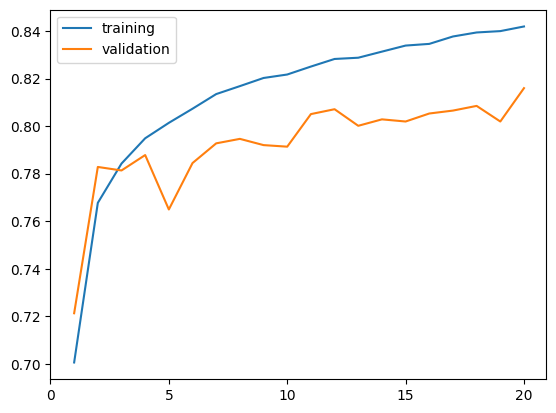

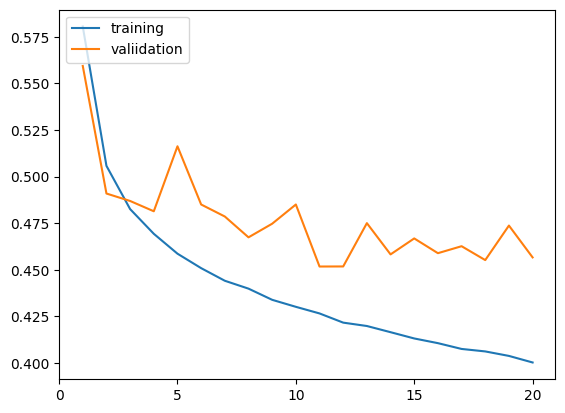

In [10]:
import matplotlib.pyplot as plt

plt.plot([*range(1,len(train_acc_record)+1)] , train_acc_record , label = "training")
plt.plot([*range(1,len(train_acc_record)+1)] , valid_acc_record , label = "validation")

plt.xticks(np.arange(0, n_epochs+1, 5))
plt.legend(loc="upper left")

plt.savefig('acc.png')
plt.show()


plt.plot([*range(1,len(train_acc_record)+1)] , train_loss_record , label = "training")
plt.plot([*range(1,len(train_acc_record)+1)] , valid_loss_record , label = "valiidation")

plt.xticks(np.arange(0, n_epochs+1, 5))
plt.legend(loc="upper left")

plt.savefig('loss.png')
plt.show()